# OpenVINO™ Explainable AI Toolkit (1/3): Basic

<div class="alert alert-block alert-danger"> <b>Important note:</b> This notebook requires python >= 3.10. Please make sure that your environment fulfill to this requirement before running it </div>

This is the **first notebook** in series of exploring [OpenVINO™ Explainable AI (XAI)](https://github.com/openvinotoolkit/openvino_xai/):

1. [**OpenVINO™ Explainable AI Toolkit (1/3): Basic**](../explainable-ai-1-basic/README.md)
2. [OpenVINO™ Explainable AI Toolkit (2/3): Deep Dive](../explainable-ai-2-deep-dive/README.md)
3. [OpenVINO™ Explainable AI Toolkit (3/3): Saliency map interpretation](../explainable-ai-3-map-interpretation/README.md)

It covers the basic introduction to [XAI](https://github.com/openvinotoolkit/openvino_xai/) toolkit and shows how to explain predictions of an image classification model.

[OpenVINO™ Explainable AI (XAI)](https://github.com/openvinotoolkit/openvino_xai/) provides a suite of XAI algorithms for the analysis of OpenVINO IR model predictions. Generated saliency maps can be used to evaluate model reasoning when making predictions.

A **saliency map** is a visualization technique that highlights regions of the interest in an image from the model perspective. For example, it can be used to explain classification model predictions for a particular label. Here is an example of a saliency map that you will get in this notebook:

![](https://github.com/openvinotoolkit/openvino_xai/assets/17028475/ccb67c0b-c58e-4beb-889f-af0aff21cb66)

A pre-trained [MobileNetV3 model](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/mobilenet-v3-small-1.0-224-tf/README.md) from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/) is used in this tutorial.


#### Table of contents:

- [Imports](#Imports)
- [Download the Model and data samples](#Download-the-Model-and-data-samples)
- [Load the Model](#Load-the-Model)
- [Select inference device](#Select-inference-device)
- [Load an Image](#Load-an-Image)
- [Do Inference](#Do-Inference)
- [Create Explainer](#Create-Explainer)
- [Do Explanation](#Do-Explanation)
### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/explainable-ai-1-basic/explainable-ai-1-basic.ipynb" />


In [ ]:
import platform

# Install openvino package
%pip install -q "openvino>=2024.2.0" opencv-python tqdm

# Install openvino xai package
%pip install -q --no-deps "openvino-xai>=1.1.0"
%pip install -q -U "numpy==1.*"
%pip install -q scipy

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

## Imports
[back to top ⬆️](#Table-of-contents:)


In [2]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
import openvino_xai as xai

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file, device_widget

## Download the Model and data samples
[back to top ⬆️](#Table-of-contents:)


In [ ]:
base_artifacts_dir = Path("./artifacts").expanduser()

model_name = "v3-small_224_1.0_float"
model_xml_name = f"{model_name}.xml"
model_bin_name = f"{model_name}.bin"

model_xml_path = base_artifacts_dir / model_xml_name

base_url = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/models/mobelinet-v3-tf/FP32/"

if not model_xml_path.exists():
    download_file(base_url + model_xml_name, model_xml_name, base_artifacts_dir)
    download_file(base_url + model_bin_name, model_bin_name, base_artifacts_dir)
else:
    print(f"{model_name} already downloaded to {base_artifacts_dir}")

## Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [ ]:
device = device_widget()
device

## Load the Model
[back to top ⬆️](#Table-of-contents:)


In [5]:
core = ov.Core()
model = core.read_model(model=model_xml_path)
compiled_model = core.compile_model(model=model, device_name=device.value)

## Load an Image
[back to top ⬆️](#Table-of-contents:)


'data/coco.jpg' already exists.


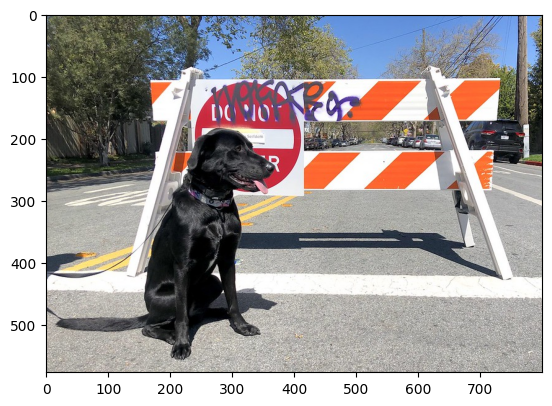

In [6]:
# Download the image from the openvino_notebooks storage
image_filename = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco.jpg",
    directory="data",
)

# The MobileNet model expects images in RGB format.
image = cv2.cvtColor(cv2.imread(filename=str(image_filename)), code=cv2.COLOR_BGR2RGB)

# Resize to MobileNet image shape.
input_image = cv2.resize(src=image, dsize=(224, 224))

# Reshape to model input shape.
input_image = np.expand_dims(input_image, 0)
plt.imshow(image)

## Do Inference
[back to top ⬆️](#Table-of-contents:)

In [7]:
result_infer = compiled_model([input_image])[0]
result_index = np.argmax(result_infer)

In [ ]:
imagenet_filename = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/datasets/imagenet/imagenet_2012.txt",
    directory="data",
)

imagenet_classes = imagenet_filename.read_text().splitlines()

In [9]:
# The model description states that for this model, class 0 is a background.
# Therefore, a background must be added at the beginning of imagenet_classes.
imagenet_classes = ["background"] + imagenet_classes

print(f"class index: {result_index}")
print(f"class name: {imagenet_classes[result_index]}")
print(f"class score: {result_infer[0][result_index]:.2f}")

class index: 206
class name: n02099267 flat-coated retriever
class score: 0.76


## Create Explainer
[back to top ⬆️](#Table-of-contents:)

In [10]:
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
)

INFO:openvino_xai:Assigning preprocess_fn to identity function assumes that input images were already preprocessed by user before passing it to the model. Please define preprocessing function OR preprocess images beforehand.
INFO:openvino_xai:Target insertion layer is not provided - trying to find it in auto mode.
INFO:openvino_xai:Using ReciproCAM method (for CNNs).
INFO:openvino_xai:Explaining the model in white-box mode.


## Do Explanation
[back to top ⬆️](#Table-of-contents:)

Explainer generates explanation which contains saliency maps ({target: saliency_map}). For classification, targets are indices of the classes.

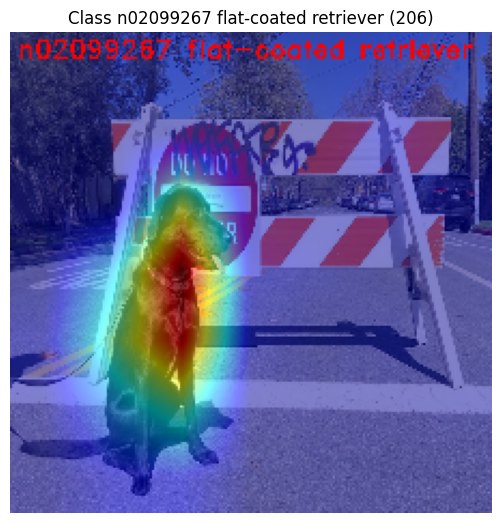

In [11]:
explanation = explainer(
    data=input_image,
    targets=result_index,  # can be a single target or a container of targets
    label_names=imagenet_classes,  # optional, list of label names
    overlay=True,  # saliency map overlays over the input image, defaults to False
)
explanation.plot()

<b>Note:</b> by default, overlay is applied over the image in the `data` argument. 
In this case, `data` was preprocessed (e.g. resized to 224x224), but still recognizable by human.
In order for the overlay to applied over the original image, provide original image with `original_image` argument (please refer to [OpenVINO™ Explainable AI Toolkit (2/3): Deep Dive](../explainable-ai-2-deep-dive/README.md)).

Above saliency map can help to answer the question: 
"Which part of the image mostly contributes to the model predicted class: (206, 'n02099267 flat-coated retriever')?" 

Observing saliency map overlay, it might be concluded that the model is using the right features (pixels) to make a prediction.

Save saliency maps for the further visual analysis:

In [12]:
explanation.save(base_artifacts_dir)